In [1]:
try:
    from chgnet.model import CHGNet
except ImportError:
    # install CHGNet (only needed on Google Colab or if you didn't install CHGNet yet)
    !pip install chgnet

  Using cached chgnet-0.4.0-cp311-cp311-macosx_10_9_universal2.whl.metadata (16 kB)
  Using cached ase-3.23.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached Cython-3.0.11-cp311-cp311-macosx_10_9_x86_64.whl.metadata (3.2 kB)
  Using cached numpy-2.1.3-cp311-cp311-macosx_14_0_x86_64.whl.metadata (62 kB)
  Using cached nvidia_ml_py3-7.352.0-py3-none-any.whl
  Using cached pymatgen-2024.11.13-cp311-cp311-macosx_10_13_x86_64.whl
INFO: pip is looking at multiple versions of chgnet to determine which version is compatible with other requirements. This could take a while.
  Using cached chgnet-0.3.8-cp311-cp311-macosx_10_9_universal2.whl.metadata (16 kB)
  Using cached torch-2.2.2-cp311-none-macosx_10_9_x86_64.whl.metadata (25 kB)
  Using cached scipy-1.14.1-cp311-cp311-macosx_14_0_x86_64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached monty-2024.10.21-py3-none-any.whl.metadata (3.6 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadat

In [2]:
import numpy as np
from pymatgen.core import Structure

# If the above line fails in Google Colab due to numpy version issue,
# please restart the runtime, and the problem will be solved

[-1.62290620803833, -5.62188720703125, -7.154989719390869, -1.9189749956130981, -2.382286548614502, -1.559761643409729, -3.806004762649536, -1.7435011863708496, -1.9059760570526123, -3.837799310684204, -3.8006298542022705, -8.508437156677246, -51.19171905517578, -8.185920715332031, -6.746139049530029, -17.095401763916016, -8.473137855529785, -33.43149185180664, -54.15860366821289, -54.33728790283203, -3.6368627548217773, -3.3904061317443848, -19.289003372192383, -39.573509216308594, -24.190166473388672, -45.609474182128906, -6.134239673614502, -39.43974685668945, -6.754608154296875, -23.901233673095703, -9.875981330871582, -108.87989807128906, -9.892486572265625, -19.671947479248047, -9.653609275817871, -50.500694274902344, -3.3686299324035645, -9.871705055236816, -39.58368682861328, -161.25111389160156, -99.72221374511719, -87.01104736328125, -105.5296401977539, -43.506404876708984, -56.193199157714844, -63.678985595703125, -235.76515197753906, -24.50178337097168, -24.92538070678711, 

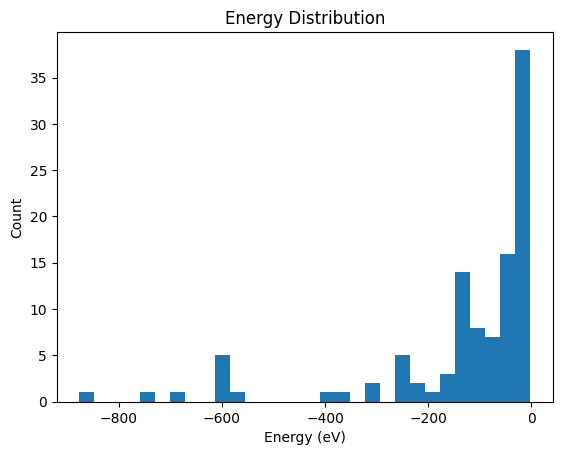

Average energy: -130.894 eV
Energy std: 180.671 eV


In [12]:
from pymatgen.core import Structure
from chgnet.utils import read_json
# Read JSON dataset
dataset_dict = read_json("dataset.json")

# Extract structure information
structures = []
for struct_dict in dataset_dict["structures"]:  # Note: changed to "structures"
    struct = Structure(
        lattice=struct_dict["lattice"],
        species=struct_dict["species"],
        coords=struct_dict["coords"],
        coords_are_cartesian=False  # Assume coordinates are fractional
    )
    structures.append(struct)

# Extract energy, force, and stress data
energies = dataset_dict["labels"]["energies"]  # Corrected path
forces = dataset_dict["labels"]["forces"]
stresses = dataset_dict["labels"]["stresses"]
print(energies)
print(forces)
print(stresses)
# Data processing example
def process_structures(structures, energies):
    results = []
    for struct, energy in zip(structures, energies):
        # Get structure information
        composition = struct.composition
        volume = struct.volume
        density = struct.density
        
        # Store results
        result = {
            "composition": composition,
            "volume": volume,
            "density": density,
            "energy": energy
        }
        results.append(result)
    return results

# Call processing function
processed_data = process_structures(structures, energies)
import matplotlib.pyplot as plt
import numpy as np

def analyze_data(processed_data):
    # Extract energy data
    energies = [d["energy"] for d in processed_data]
    
    # Plot energy distribution histogram
    plt.figure()
    plt.hist(energies, bins=30)
    plt.xlabel('Energy (eV)')
    plt.ylabel('Count')
    plt.title('Energy Distribution')
    plt.show()
    
    # Calculate basic statistics
    print(f"Average energy: {np.mean(energies):.3f} eV")
    print(f"Energy std: {np.std(energies):.3f} eV")

# Call analysis function
analyze_data(processed_data)

In [9]:
from chgnet.data.dataset import StructureData, get_train_val_test_loader

In [ ]:
dataset = StructureData(
    structures=structures,
    energies=energies,
    # energies= energies_per_atom,
    forces=forces,
    stresses=stresses,  # can be None
    magmoms=None,  # can be None
)
train_loader, val_loader, test_loader = get_train_val_test_loader(
    dataset, batch_size=8, train_ratio=0.9, val_ratio=0.05
)

StructureData imported 107 structures


In [15]:
from chgnet.model import CHGNet
from chgnet.trainer import Trainer

# Load pretrained CHGNet
chgnet = CHGNet.load()

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on mps


In [16]:
# Optionally fix the weights of some layers
for layer in [
    chgnet.atom_embedding,
    chgnet.bond_embedding,
    chgnet.angle_embedding,
    chgnet.bond_basis_expansion,
    chgnet.angle_basis_expansion,
    chgnet.atom_conv_layers[:-1],
    chgnet.bond_conv_layers,
    chgnet.angle_layers,
]:
    for param in layer.parameters():
        param.requires_grad = False

In [20]:
# Define Trainer
trainer = Trainer(
    model=chgnet,
    targets="efs",
    # targets="efsm",
    optimizer="Adam",
    scheduler="CosLR",
    criterion="MSE",
    epochs=5,
    learning_rate=1e-2,
    use_device="cpu",
    print_freq=6,
)

In [21]:
trainer.train(train_loader, val_loader, test_loader)

Begin Training: using cpu device
training targets: efs
Epoch: [0][1/12] | Time (4.225)(0.603) | Loss 116148.8594(116148.8594) | MAE e 228.273(228.273)  f 12.906(12.906)  s 14.669(14.669)  
Epoch: [0][6/12] | Time (2.799)(0.145) | Loss 44439.8164(57744.9959) | MAE e 103.962(148.179)  f 5.890(9.572)  s 17.940(17.988)  
Epoch: [0][12/12] | Time (1.991)(0.098) | Loss 5056.3174(53787.4364) | MAE e 47.671(133.975)  f 2.446(7.506)  s 5.492(12.570)  
*   e_MAE (122.793) 	f_MAE (3.069) 	s_MAE (5.094) 	
Epoch: [1][1/12] | Time (2.675)(0.000) | Loss 76015.2656(76015.2656) | MAE e 139.928(139.928)  f 3.049(3.049)  s 6.605(6.605)  
Epoch: [1][6/12] | Time (2.150)(0.001) | Loss 55261.4180(60989.9688) | MAE e 140.839(137.799)  f 6.409(3.210)  s 9.242(5.500)  
Epoch: [1][12/12] | Time (1.762)(0.001) | Loss 917.4154(53243.9696) | MAE e 20.287(131.583)  f 0.456(4.111)  s 1.590(11.049)  
*   e_MAE (121.686) 	f_MAE (1.524) 	s_MAE (2.255) 	
Epoch: [2][1/12] | Time (1.249)(0.000) | Loss 56418.1992(56418.199

In [22]:
model = trainer.model
best_model = trainer.best_model  # best model based on validation energy MAE